In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from tqdm import tqdm

In [2]:
class LCN(nn.Module):
    
    def __init__(self, input_size, simple_number, simple_size, v4_size, v4_stride, phis_sfs, training_size, phis = True, sfs = False, alpha = 0.0001):

        """
        Initialize network parameters.
        """
        
        super(LCN, self).__init__()
        self.input_size = input_size
        self.simple_number = simple_number
        self.simple_size = simple_size
        self.phis_sfs = phis_sfs
        self.phis = phis
        self.sfs = sfs
        
        self.training_size = training_size
        self.alpha = alpha
        self.dimensions = self.input_size - self.simple_size + 1
        
        self.v4_size = v4_size
        self.v4_stride = v4_stride
        self.v4_dimensions = int(((self.dimensions - self.v4_size)/self.v4_stride) + 1)
        
        self.simple_weight = torch.nn.Parameter(self.init_weights())
        
        self.v4_weight = torch.nn.Parameter(self.init_gaussian_weights().view(
            self.simple_number, self.v4_dimensions, self.v4_dimensions, self.v4_size ** 2), requires_grad = False)
        
        self.decision = nn.Linear(self.v4_dimensions*self.v4_dimensions*self.simple_number, 2)
        self.decision.weight = torch.nn.Parameter(
            torch.zeros((2, self.v4_dimensions*self.v4_dimensions*self.simple_number)))
        
        
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
        else:
            self.device = torch.device("cpu")
    
    def init_weights(self):
        
        """
        Initialize V1 simple cell weights with gabor filters at different orientations and different phases/spatial 
        frequencies, depending on what is chosen when initializing network. Returns torch tensor weights.
        """        
        angles = self.remove_ambiguous_stimuli(0, np.pi, self.simple_number, even_space = True)
        if self.phis == True:
            self.phis_sfs_range = np.linspace(0, np.pi, self.phis_sfs)
            weights = []
            for i in range(self.simple_number):
                for j in range(self.phis_sfs):
                    for k in range(self.dimensions ** 2):
                        theta = angles[i]
                        phi = self.phis_sfs_range[j]
                        kernel = self.generate_gabor(self.simple_size, theta, phi, 5)
                        noise = np.random.normal(0, 0.05, (self.simple_size, self.simple_size))
                        kernel = kernel + noise
                        weights.append(kernel)

            weight = torch.stack(weights).view(
                1, self.simple_number*self.phis_sfs, 1, self.dimensions, self.dimensions, self.simple_size ** 2)
            return weight
        if self.sfs == True:
            self.phis_sfs_range = np.linspace(1.1, 14, self.phis_sfs)
            weights = []
            for i in range(self.simple_number):
                for j in range(self.phis_sfs):
                    for k in range(self.dimensions ** 2):
                        theta = angles[i]
                        lamda = self.phis_sfs_range[j]
                        kernel = self.generate_gabor(self.simple_size, theta, 0, lamda)
                        noise = torch.normal(0, 0.05, (self.simple_size, self.simple_size))
                        kernel = kernel + noise
                        weights.append(kernel)

            weight = torch.stack(weights).view(
                1, self.simple_number*self.phis_sfs, 1, self.dimensions, self.dimensions, self.simple_size ** 2)
            return weight
    
    
    def init_gaussian_weights(self):
        
        """
        Initialize V1 complex cell weights with gaussian filters. Returns torch tensor weights.
        """
        
        v4 = torch.empty(self.simple_number, self.v4_dimensions, self.v4_dimensions, self.v4_size, self.v4_size)
        for orientation in range(self.simple_number):
            for i in range(self.v4_dimensions):
                for j in range(self.v4_dimensions):
                    v4[orientation][i][j] = self.generate_gaussian(self.v4_size, 3)
        return v4
    
    def generate_gabor(self, size, theta, phi, lamda, random_sf = False):
        
        """
        Generates one gabor matrix. Takes in gabor size, angle, phase, spatial frequency as arguments and returns a torch
        tensor gabor matrix. Setting random_sf = True creates a gabor with a random spatial frequency.
        """
        
        ksize = size
        sigma = 3
        if random_sf == True:
            lamda = np.random.uniform(1.1, 13)
        gamma = 0.5
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        return torch.tensor(kernel).view(1, 1, size, size).float()
    
    def generate_gaussian(self, kernlen, std):

        """
        Generates V4 gaussian filters. Takes filter size and standard deviation as 
        arguments and returns torch tensor weights.
        """
        
        
        n = torch.arange(0, kernlen) - (kernlen - 1.0) / 2.0
        sig2 = 2 * std * std
        w = torch.exp(-n ** 2 / sig2)

        gkern1d = w.reshape(kernlen)
        gkern2d = torch.outer(gkern1d, gkern1d)
        return gkern2d
    
    def remove_ambiguous_stimuli(self, angle1, angle2, size, even_space = False):
        
        """
        Function returns a numpy list of angles that are unambiguously clockwise or anticlockwise relative to 0°. 
        Ambiguous angles include -pi/2, 0, pi/2 and pi which are not clockwise or anticlockwise relative to 0°.
        A constant is either added or subtracted from these angles to make them unambiguous. Takes in the two angles 
        and the number of angles as arguments. Setting even_space = True returns a numpy list of angles that are evenly 
        spaced across 360° by removing the last element in the list.
        """
        
        stimuli = [-np.pi/2, 0, np.pi/2, np.pi]
        if even_space == True:
            x = np.linspace(angle1, angle2, size+1)
            x = np.delete(x, -1)
            ambiguous = True
            while ambiguous == True:
                for i in stimuli[0:2]:
                    x = np.where(x == i, i+0.1, x)
                for i in stimuli[2:4]:
                    x = np.where(x == i, i-0.1, x)            
                x = np.linspace(x[0], x[-1], size)
                if -np.pi/2 in x or 0 in x or np.pi/2 in x:
                    ambiguous = True
                else:
                    ambiguous = False

        if even_space == False:
            x = np.linspace(angle1, angle2, size)
            ambiguous = True
            while ambiguous == True:
                for i in stimuli[0:2]:
                    x = np.where(x == i, i+0.1, x)
                for i in stimuli[2:4]:
                    x = np.where(x == i, i-0.1, x)            
                x = np.linspace(x[0], x[-1], size)
                if -np.pi/2 in x or 0 in x or np.pi/2 in x:
                    ambiguous = True
                else:
                    ambiguous = False
        return x
    
    def binary_loss(self, scores, desired_output):
        
        """
        Loss function. Takes in prediction and desired output as arguments and returns cross entropy loss. 
        """
        
        loss = nn.CrossEntropyLoss()
        return loss(scores, desired_output)
    
    def inputting(self, angle1, angle2, random_sf):
        
        """
        Creates gabor filters to train network with. Takes in two angles that give the range of orientation of gabors
        and a Boolean random_sf to determine if spatial frequency of gabors is randomized. Returns a torch tensor 
        consisting of all the training gabors. 
        """
        
        self.labels = []
        self.inputs = []
    
        x = self.remove_ambiguous_stimuli(angle1, angle2, self.training_size, even_space = False)

        for i in range(self.training_size):
            theta = x[i]
            phi = np.random.uniform(0, np.pi)
            kernel = self.generate_gabor(self.input_size, theta, phi, 5, random_sf = random_sf)
            self.inputs.append(kernel)
            if 0 < theta < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            self.labels.append(label)
        self.input = torch.stack(self.inputs).view(self.training_size, 1, self.input_size, self.input_size)#.to(self.device)
        return self.input

    
    def desired_outputting(self):
        
        """
        Returns a torch tensor consisting of the correct labels of the training set. 
        """
        
        self.desired_output = torch.tensor(self.labels)#.to(self.device)
        return self.desired_output
    
    def forward(self, x):
        
        """
        Forward function. Takes in one training gabor filter as argument and creates a prediction.
        """
        
        x = x.unfold(2, self.simple_size, 1).unfold(3, self.simple_size, 1)
        x = x.contiguous().view(*x.size()[:-2], -1)
        out = (x.unsqueeze(1) * self.simple_weight).sum([2, -1])
        pools = []
        for i in range(0, self.simple_number*self.phis_sfs, self.phis_sfs):
            pool = (torch.sum(out[0][i:i+self.phis_sfs] ** 2, dim = 0)/(self.phis_sfs*5000)).view(
                1, self.dimensions, self.dimensions)
            pools.append(pool)
        pools = torch.stack(pools).view(self.simple_number, self.dimensions, self.dimensions)
        out = pools.unfold(1, self.v4_size, self.v4_stride).unfold(2, self.v4_size, self.v4_stride)
        out = out.contiguous().view(*out.size()[:-2], -1)
        out = (out.unsqueeze(1)*self.v4_weight).sum([1, -1])
        out = out.view(1, self.v4_dimensions*self.v4_dimensions*self.simple_number)
#         out = pools.view(1, self.dimensions*self.dimensions*self.simple_number)
        out = self.decision(out.float())
        return out
    
    def mean_train(self, iterations, optimizer):
        
        """
        Training loop. Takes in the number of iteractions and optimizer as arguments and trains the network over the 
        number of iteractions. Calculates mean loss over batch size and optimizes over this loss. 
        """
        
        self.before_v1weight = self.simple_weight.clone()
        self.before_v4weight = self.v4_weight.clone()
        self.before_decision_weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_decision_weights = []
        
        self.losses = []
        self.training_scores = []

        for i in tqdm(range(iterations)):
            optimizer.zero_grad()
            self.training_score = 0
            loss2 = torch.empty(self.training_size)
            
            for j in range(self.training_size):
                self.scores = self.forward(self.input[j][0].view(1, 1, self.input_size, self.input_size))
                loss1 = self.binary_loss(self.scores, self.desired_output[j].view(1))
                if torch.argmax(self.scores) == self.desired_output[j]:
                    self.training_score += 1
                loss2[j] = loss1
            
            
            loss = torch.sum(loss2)/self.training_size
            self.losses.append(loss)
            
            self.training_score = self.training_score/self.training_size * 100
            self.training_scores.append(self.training_score)
            
            self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
            self.before_decision_weights.append(self.decision_weight_change(self.before_decision_weight, self.decision.weight))
            
            loss.backward()
            optimizer.step()
            
        self.v1_tuning_curve()
        self.v4_tuning_curve()
        
    def double_train(self, iterations, optimizer, angle1, angle2, test_angle, test_size):
        
        """
        Training loop for sequential curriculum. Takes in the number of iteractions, optimizer, the first angle to be
        trained on (will be trained on -angle and angle), the second angle to be trained on after training on first 
        angle, the test angle and the test size. For each iteraction, the network is tested on the test_size number of 
        gabors between -test_angle and test_angle to see how well it generalizes. 
        """
        
        self.before_v1weight = self.simple_weight.clone()
        self.before_v4weight = self.v4_weight.clone()
        self.before_decision_weight = self.decision.weight.clone()
        
        self.before_v1weights = []
        self.before_decision_weights = []
        
        self.losses = []
        self.training_scores = []
        self.generalize_error = []
        self.generalize_perform = []
        for angle in [angle1, angle2]:
            input = self.inputting(-angle, angle, random_sf = False)
            desired_output = self.desired_outputting()
            for i in tqdm(range(iterations)):
                optimizer.zero_grad()
                self.training_score = 0
                loss2 = torch.empty(self.training_size)

                for j in range(self.training_size):
                    self.scores = self.forward(input[j][0].view(1, 1, self.input_size, self.input_size))
                    loss1 = self.binary_loss(self.scores, desired_output[j].view([1]))
                    if torch.argmax(self.scores) == desired_output[j]:
                        self.training_score += 1
                    loss2[j] = loss1

                loss = torch.sum(loss2)/self.training_size
                self.losses.append(loss)

                self.training_score = self.training_score/self.training_size * 100
                self.training_scores.append(self.training_score)

                generalize = self.generalization(test_angle, test_size)
                self.generalize_error.append(self.general_mean_error)
                self.generalize_perform.append(self.generalization_score)

                self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.simple_weight))
                self.before_decision_weights.append(self.decision_weight_change(self.before_decision_weight, self.decision.weight))

                loss.backward()
                optimizer.step()
    
        self.v1_tuning_curve()
        self.v4_tuning_curve()
        
    def plot_training_error(self, color):
        
        """
        Plots the training error for each iteraction. Calculated by mean loss between prediction and desired output
        for each batch of training data. Takes in color as argument. 
        """
        
        plt.plot([loss.detach().cpu().numpy() for loss in self.losses], color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")

    def plot_training_performance(self, color):
        
        """
        Plots the training performance for each iteraction. If the prediction has a higher value for the accurate 
        rotation (clockwise vs anticlockwise), the model is assumed to have produced the correct output and so the
        score increases by 1. Percentage accuracy is then calculated after. Takes in color as argument. 
        """
        
        plt.plot(self.training_scores, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")
        
    def generalization(self, angle, test_size):
        
        """
        Function used to test model against test_size number of gabors between -angle and angle to measure 
        generalization error and performance.
        """
        
        angles = self.remove_ambiguous_stimuli(-angle, angle, test_size, even_space = False)
        self.generalization_score = 0
        general_error = []
        for i in range(test_size):
            gabor = self.generate_gabor(self.input_size, angles[i], phi = 0, lamda = 5).clone().detach()
            if 0 < angles[i] < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            with torch.no_grad():
                a = self.forward(gabor)
                if torch.argmax(a) == label:
                    self.generalization_score += 1
                general_error.append(self.binary_loss(a, label))
        self.generalization_score = self.generalization_score/test_size * 100
        self.general_mean_error = np.mean(general_error)

    def plot_generalization_performance(self, color):
        
        """
        Plots generalization performance. Takes in color as argument.
        """
        
        plt.plot(self.generalize_perform, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")

    def plot_generalization_error(self, color):
        
        """
        Plots generalization error. Takes in color as argument. 
        """
        
        plt.plot(self.generalize_error, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")
   
    def plot_angle_performance(self, number, color):
        
        """
        Plots the angle/performance graph for the model. Takes in the number of test angles and plot color as 
        arguments. Creates the number of angles between 0 and pi/2 and tests model with test angles between -angle 
        and angle. 
        """
        
        angles = self.remove_ambiguous_stimuli(0, np.pi/2, number, even_space = False)
        scores = []
        for i in range(number):
            self.generalization(angles[i], 50)
            scores.append(self.generalization_score)
        plt.plot((180 * angles)/np.pi, scores, color = color)
        plt.xlabel("Separation angle (Degrees)")
        plt.ylabel("Performance (%)")

    def v1_weight_change(self, before, after):
        
        """
        Calculates frobenius norm of difference between weights in V1 simple cells and initial weights for each iteraction 
        of training. Takes in initial weights and current weights as arguments and returns scalar value.
        """
        
        diff = after - before
        net_diff = []
        for i in diff.view(self.simple_number*self.phis_sfs, 1, self.dimensions, self.dimensions, self.simple_size ** 2):
            for j in i.view(self.dimensions, self.dimensions, self.simple_size ** 2):
                for k in j:
                    net_diff.append(torch.linalg.norm(k.view(self.simple_size, self.simple_size), ord = 'fro').item())
        return np.mean(net_diff)
    
    def decision_weight_change(self, before, after):
        
        """
        Calculates frobenius norm of difference between weights in decision layer and initial weights for each iteraction
        of training. Takes in initial weights and current weights as arguments and returns scalar value. 
        """
        
        diff = after - before
        net_diff = (torch.linalg.norm(
            diff.view(2, self.v4_dimensions*self.v4_dimensions*self.simple_number), ord = 'fro').item())
        return net_diff
    
    def plot_weight_change(self, color, v1 = False, decision = False):
        
        """
        Plot weight changes. Takes in plot color as argument. Setting v1 = True plots V1 simple cell weight change and
        setting decision = True plots deicision layer weight changes. 
        """
        
        if v1 == True:
            plt.plot(self.before_v1weights, color = color)
        if decision == True:
            plt.plot(self.before_decision_weights, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Weight change")
    
    def v1_tuning_curve(self):
        
        """
        Creates tuning curves for each gabor filter in V1 simple cell layer by testing each filter with a number of
        orientations at a fixed phase and spatial frequency. Returns a torch tensor consisting of all tuning curves 
        organized with dimensions orientation, spatial frequency, horizontal position, vertical position and the 
        tuning curve data plot.
        """
        
        self.tuning_curve_sample = 100
        x = np.linspace(0, np.pi, self.tuning_curve_sample)
        self.results = torch.empty(self.simple_number, self.phis_sfs, self.dimensions, self.dimensions, len(x))
        self.initial_tuning_curves = torch.empty(
            self.simple_number, self.phis_sfs, self.dimensions, self.dimensions, len(x))
        with torch.no_grad():
            for i in tqdm(range(len(x))):
                for orientation in range(self.simple_number):
                    for sf in range(self.phis_sfs):
                        for horizontal in range(len(self.simple_weight[0][self.phis_sfs * orientation + sf][0])):
                            for vertical in range(
                                len(self.simple_weight[0][self.phis_sfs * orientation + sf][0][horizontal])):
                                test = self.generate_gabor(self.simple_size, x[i], 0, 5).view(
                                    self.simple_size, self.simple_size)
                                result = torch.sum(
                                    self.simple_weight[0][self.phis_sfs * orientation + sf][0][horizontal][vertical].view(
                                        self.simple_size, self.simple_size) * test)
                                self.results[orientation][sf][horizontal][vertical][i] = result
                                
                                initial_result = torch.sum(
                                    self.before_v1weight[0][self.phis_sfs * orientation + sf][0][horizontal][vertical].view(
                                        self.simple_size, self.simple_size) * test)
                                self.initial_tuning_curves[orientation][sf][horizontal][vertical][i] = initial_result
                        
    def plot_v1_tuning_curve(self, orientation, phi_sf, position, orientations = False, phi_sfs = False, differences = False):
        
        """
        Plot tuning curves at a particular orientation index or phase/spatial frequeny index and at a particular 
        filter position. Setting orientations = True plots tuning curves at all orientations at a specified phase/
        spatial frequency. Setting phi_sfs = True plots tuning curves at all phases/spatial frequencies (determined
        during network initialization) at a specified orientation. Setting differences = True plots difference in
        responses using initial V1 simple cell weights and trained weights. 
        """
        
        x = np.linspace(0, np.pi, self.tuning_curve_sample)
        x = (x * 180) / np.pi
        if orientations == True and differences == False:
            ranges = self.remove_ambiguous_stimuli(0, np.pi, self.simple_number, even_space = True)
            ranges = (ranges * 180) / np.pi
            for i in range(self.simple_number):
                plt.plot(x, self.results[i, phi_sf, position, position, :])
            plt.legend([round(ranges[i], 1) for i in range(self.simple_number)])
            plt.ylabel("Response")
                
        if phi_sfs == True and differences == False:
            ranges = np.linspace(self.phis_sfs_range[0], self.phis_sfs_range[-1], self.phis_sfs)
            for i in range(self.phis_sfs):
                plt.plot(x, self.results[orientation, i, position, position, :])
            plt.legend([round(ranges[i], 1) for i in range(self.phis_sfs)])
            plt.ylabel("Response")
            
        if orientations == True and differences == True:
            ranges = self.remove_ambiguous_stimuli(0, np.pi, self.simple_number, even_space = True)
            ranges = (ranges * 180) / np.pi
            difference = self.results - self.initial_tuning_curves
            for i in range(self.simple_number):
                plt.plot(x, difference[i, phi_sf, position, position, :])
            plt.legend([round(ranges[i], 1) for i in range(self.simple_number)])
            plt.ylabel("Difference in response")
            
        
        if phi_sfs == True and differences == True:
            ranges = np.linspace(self.phis_sfs_range[0], self.phis_sfs_range[-1], self.phis_sfs)
            difference = self.results - self.initial_tuning_curves
            for i in range(self.phis_sfs):
                plt.plot(x, difference[orientation, i, position, position, :])
            plt.legend([round(ranges[i], 1) for i in range(self.phis_sfs)])
            plt.ylabel("Difference in response")

        
        
        plt.xlabel("Angle (Degrees)")
        
    def tuning_params(self, position):
        
        """
        Calculates the amplitude and bandwidth of tuning curves. Takes position of gabor filter as argument.  
        """
        
        
        def find_nearest(tensor, value):
            idx = (torch.abs(tensor - value)).argmin()
            return idx.item()
        
        x = np.linspace(0, np.pi, self.tuning_curve_sample)
        x = (x * 180) / np.pi
        self.after_amplitudes = []
        self.after_bandwidths = []
        
        self.before_amplitudes = []
        self.before_bandwidths = []
        
        for i in range(self.simple_number):
            for j in range(self.phis_sfs):
                
                curve = self.results[i, j, position, position, :]
                initial_params = self.initial_tuning_curves[i, j, position, position, :]
                amplitude = curve.max() - curve.min()
                self.after_amplitudes.append(amplitude)
                
                halfmax_amplitude = torch.abs(curve.max()) - torch.abs(curve.min())
                halfmax = halfmax_amplitude/2
                halfmax_index1 = find_nearest(curve, halfmax)
                temporary = torch.cat([curve[0:halfmax_index1], curve[halfmax_index1+1:]])
                halfmax_index2 = find_nearest(temporary, halfmax)
                
                add = 0
                while halfmax_index1 - 2 <= halfmax_index2 <= halfmax_index1 + 2:
                    temporary = torch.cat([temporary[0:halfmax_index2], temporary[halfmax_index2+1:]])
                    halfmax_index2 = find_nearest(temporary, halfmax)
                    add += 1
                if halfmax_index1 < halfmax_index2:
                    halfmax_index2 = halfmax_index2 + 1 + add
                
                try1 = np.abs(x[halfmax_index1] - x[halfmax_index2])
                try2 = 180 - np.abs(x[halfmax_index1] - x[halfmax_index2])
                if try1 < try2:
                    bandwidth = try1
                else:
                    bandwidth = try2
                self.after_bandwidths.append(bandwidth)
                
                amplitude2 = initial_params.max() - initial_params.min()
                self.before_amplitudes.append(amplitude2)
            
                halfmax2_amplitude2 = torch.abs(initial_params.max()) - torch.abs(initial_params.min())
                halfmax2 = halfmax2_amplitude2/2
                halfmax2_index1 = find_nearest(initial_params, halfmax2)
                temporary2 = torch.cat([initial_params[0:halfmax2_index1], initial_params[halfmax2_index1+1:]])
                halfmax2_index2 = find_nearest(temporary2, halfmax2)
                
                add = 0
                while halfmax2_index1 - 2 <= halfmax2_index2 <= halfmax2_index1 + 2:
                    temporary2 = torch.cat([temporary2[0:halfmax2_index2], temporary2[halfmax2_index2+1:]])
                    halfmax2_index2 = find_nearest(temporary2, halfmax2)
                    add += 1
                if halfmax2_index1 < halfmax2_index2:
                    halfmax2_index2 = halfmax2_index2 + 1 + add
                try1 = np.abs(x[halfmax2_index1] - x[halfmax2_index2])
                try2 = 180 - np.abs(x[halfmax2_index1] - x[halfmax2_index2])
                if try1 < try2:
                    bandwidth2 = try1
                else:
                    bandwidth2 = try2
                self.before_bandwidths.append(bandwidth2)
          
        self.mean_after_amplitude = np.mean(self.after_amplitudes)
        self.std_after_amplitude = np.std(self.after_amplitudes)
        
        self.mean_after_bandwidth = np.mean(self.after_bandwidths)
        self.std_after_bandwidth = np.std(self.after_bandwidths)
        
        self.mean_before_amplitude = np.mean(self.before_amplitudes)
        self.std_before_amplitude = np.std(self.before_amplitudes)
        
        self.mean_before_bandwidth = np.mean(self.before_bandwidths)
        self.std_before_bandwidth = np.std(self.before_bandwidths)
        
        self.amplitude_difference = ((self.mean_after_amplitude - self.mean_before_amplitude)/self.mean_before_amplitude)*100      
        self.bandwidth_difference = ((self.mean_after_bandwidth - self.mean_before_bandwidth)/self.mean_before_bandwidth)*100

    def v4_tuning_curve(self):

        x = np.linspace(0, np.pi, self.tuning_curve_sample)
        self.v4_results = torch.empty(self.simple_number, self.v4_dimensions, self.v4_dimensions, len(x))
        self.v4_initial_tuning_curves = torch.empty(
            self.simple_number, self.v4_dimensions, self.v4_dimensions, len(x))
        with torch.no_grad():
            for i in tqdm(range(len(x))):
                test = self.generate_gabor(self.input_size, x[i], 0, 5).view(1, 1, self.input_size, self.input_size)
                out = test.unfold(2, self.simple_size, 1).unfold(3, self.simple_size, 1)
                out = out.contiguous().view(*out.size()[:-2], -1)
                out = (out.unsqueeze(1) * self.simple_weight).sum([2, -1])
                pools = []
                for i in range(0, self.simple_number*self.phis_sfs, self.phis_sfs):
                    pool = (torch.sum(out[0][i:i+self.phis_sfs] ** 2, dim = 0)/(self.phis_sfs*5000)).view(
                        1, self.dimensions, self.dimensions)
                    pools.append(pool)
                pools = torch.stack(pools).view(self.simple_number, self.dimensions, self.dimensions)
                out = pools.unfold(1, self.v4_size, self.v4_stride).unfold(2, self.v4_size, self.v4_stride)
                out = out.contiguous().view(*out.size()[:-2], -1)
                self.out = out
                out_after = (out.unsqueeze(1)*self.v4_weight).sum([1, -1])
                out_before = (out.unsqueeze(1)*self.before_v4weight).sum([1, -1])
                
                for orientation in range(self.simple_number):
                    for horizontal in range(self.v4_dimensions):
                        for vertical in range(self.v4_dimensions):
                            self.v4_results[orientation][horizontal][vertical][i] = out_after[orientation][horizontal][vertical]
                            self.v4_initial_tuning_curves[orientation][horizontal][vertical][i] = out_before[orientation][horizontal][vertical]

    def plot_v4_tuning_curve(self, orientation, position, differences = False):
        
        x = np.linspace(0, np.pi, self.tuning_curve_sample)
        x = (x * 180) / np.pi
        if differences == False:
            ranges = self.remove_ambiguous_stimuli(0, np.pi, self.simple_number, even_space = True)
            ranges = (ranges * 180) / np.pi
            for i in range(self.simple_number):
                plt.plot(x, self.v4_results[i, position, position, :])
            plt.legend([round(ranges[i], 1) for i in range(self.simple_number)])
            plt.ylabel("Response")

            
        if differences == True:
            ranges = self.remove_ambiguous_stimuli(0, np.pi, self.simple_number, even_space = True)
            ranges = (ranges * 180) / np.pi
            difference = self.v4_results - self.v4_initial_tuning_curves
            for i in range(self.simple_number):
                plt.plot(x, difference[i, position, position, :])
            plt.legend([round(ranges[i], 1) for i in range(self.simple_number)])
            plt.ylabel("Difference in response")

        plt.xlabel("Angle (Degrees)")
        

In [126]:
np.random.seed(1)
torch.manual_seed(1)
net = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, v4_size = 11, v4_stride = 6, phis_sfs = 4, training_size = 2, 
    phis = True, sfs = False, alpha = 0.02)#.to(net.device)
x = net.inputting(-np.pi/36, np.pi/36, random_sf = False)
y = net.desired_outputting()
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net.mean_train(3000, optimizer)

net2 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, v4_size = 11, v4_stride = 6, phis_sfs = 4, training_size = 2, 
    phis = True, sfs = False, alpha = 0.02)
x = net2.inputting(-np.pi/180, np.pi/180, random_sf = False)
y = net2.desired_outputting()
optimizer = optim.SGD(net2.parameters(), lr = net2.alpha)
net2.mean_train(50, optimizer)

  2%|▏         | 53/3000 [00:12<11:21,  4.32it/s]


KeyboardInterrupt: 

tensor([[4.6342e+01, 1.5173e+02, 4.6335e+01],
        [7.5584e-01, 1.5951e+00, 7.6009e-01],
        [4.5467e-02, 6.9015e-02, 4.5718e-02],
        [2.5455e-02, 4.9629e-02, 2.3966e-02],
        [6.8119e-02, 1.0284e-01, 7.1901e-02],
        [1.4809e+00, 3.4660e+00, 1.4349e+00]], dtype=torch.float64,
       grad_fn=<SumBackward1>)

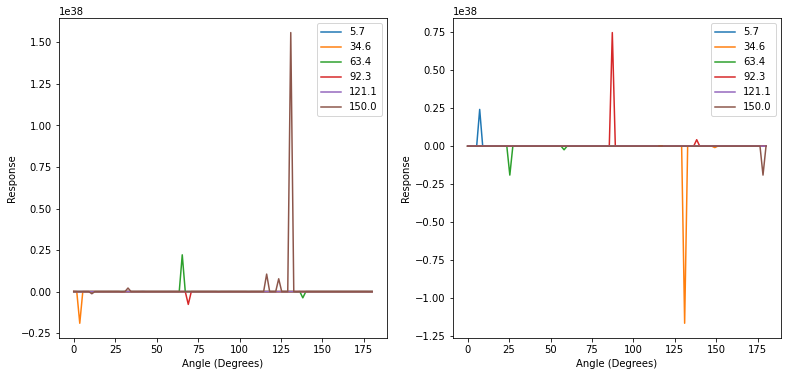

In [115]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net.plot_v4_tuning_curve(orientation = 4, position = 2, differences = False)
# plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

plt.subplot(3, 3, 2)
net.plot_v4_tuning_curve(orientation = 4, position = 1, differences = False)
# plt.title("Difference in tuning curves selective for different orientations", loc = 'center');
 

NameError: name 'net2' is not defined

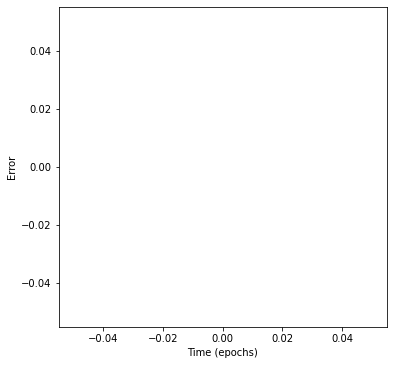

In [20]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net.plot_training_error('red')
net2.plot_training_error('blue')
plt.legend(["Low precision task training error",
            "High precision task training error"]);
plt.title("Training eror and performance for networks trained on low and high precision tasks", loc = "left")

plt.subplot(3, 3, 2)
net.plot_training_performance('red')
net2.plot_training_performance('blue')
plt.legend(["Low precision task training performance",
            "High precision task training performance"]);


In [6]:
np.random.seed(1)
torch.manual_seed(1)
net3 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, v4_size = 11, v4_stride = 6, phis_sfs = 4, 
    training_size = 2, phis = True, sfs = False, alpha = 0.02)
optimizer = optim.SGD(net3.parameters(), lr = net3.alpha)
net3.double_train(1000, optimizer, np.pi/36, np.pi/180, np.pi/16, 2)

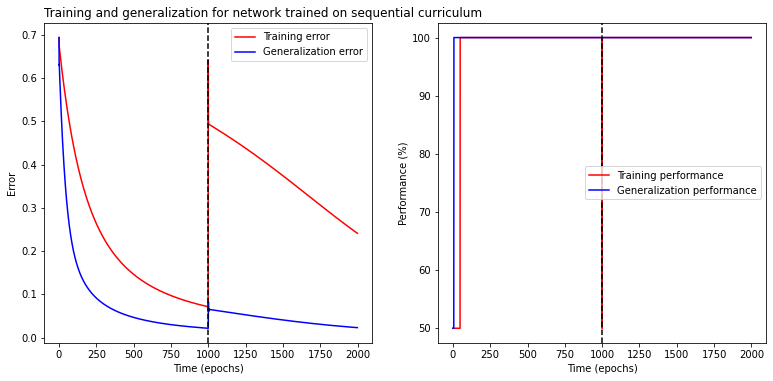

In [7]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net3.plot_training_error('red')
net3.plot_generalization_error("blue")
plt.axvline(1000, 0, 1, linestyle = 'dashed', color = 'black');
plt.legend(["Training error", "Generalization error"]);
plt.title("Training and generalization for network trained on sequential curriculum", loc = "left")

plt.subplot(3, 3, 2)
net3.plot_training_performance('red')
net3.plot_generalization_performance("blue")
plt.legend(["Training performance", "Generalization performance"]);
plt.axvline(1000, 0, 1, linestyle = 'dashed', color = 'black');


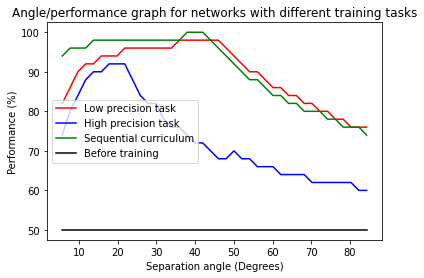

In [8]:
net4 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, v4_size = 11, v4_stride = 6, phis_sfs = 4, training_size = 2, 
    phis = True, sfs = False, alpha = 0.02)
net.plot_angle_performance(40, 'red')
net2.plot_angle_performance(40, 'blue')
net3.plot_angle_performance(40, 'green')
net4.plot_angle_performance(40, 'black')
plt.title("Angle/performance graph for networks with different training tasks");
plt.legend(["Low precision task", "High precision task", "Sequential curriculum", "Before training"]);

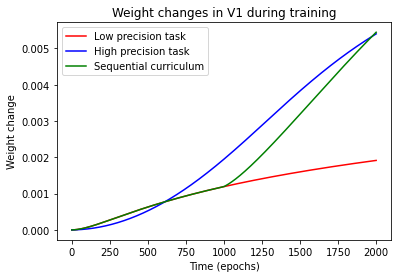

In [9]:
net.plot_weight_change('red', v1 = True)
net2.plot_weight_change('blue', v1 = True)
net3.plot_weight_change('green', v1 = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in V1 during training");

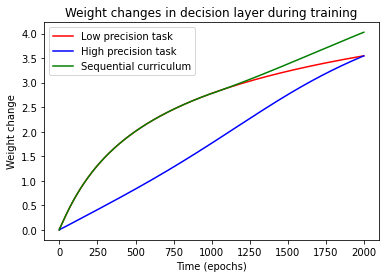

In [10]:
net.plot_weight_change('red', decision = True)
net2.plot_weight_change('blue', decision = True)
net3.plot_weight_change('green', decision = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in decision layer during training");

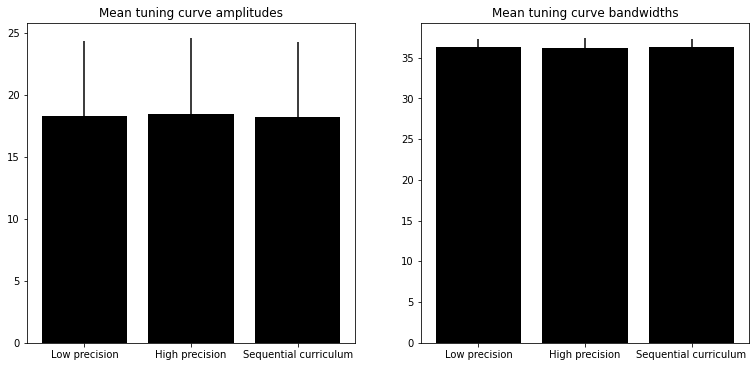

In [12]:
net.tuning_params(12)
net2.tuning_params(12)
net3.tuning_params(12)

plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.mean_after_amplitude, net2.mean_after_amplitude, net3.mean_after_amplitude], yerr = [
    net.std_after_amplitude, net2.std_after_amplitude, net3.std_after_amplitude], color = "black");
plt.title("Mean tuning curve amplitudes");

plt.subplot(3, 3, 2)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.mean_after_bandwidth, net2.mean_after_bandwidth, net3.mean_after_bandwidth], yerr = [
    net.std_after_bandwidth, net2.std_after_bandwidth, net3.std_after_bandwidth], color = "black");
plt.title("Mean tuning curve bandwidths");

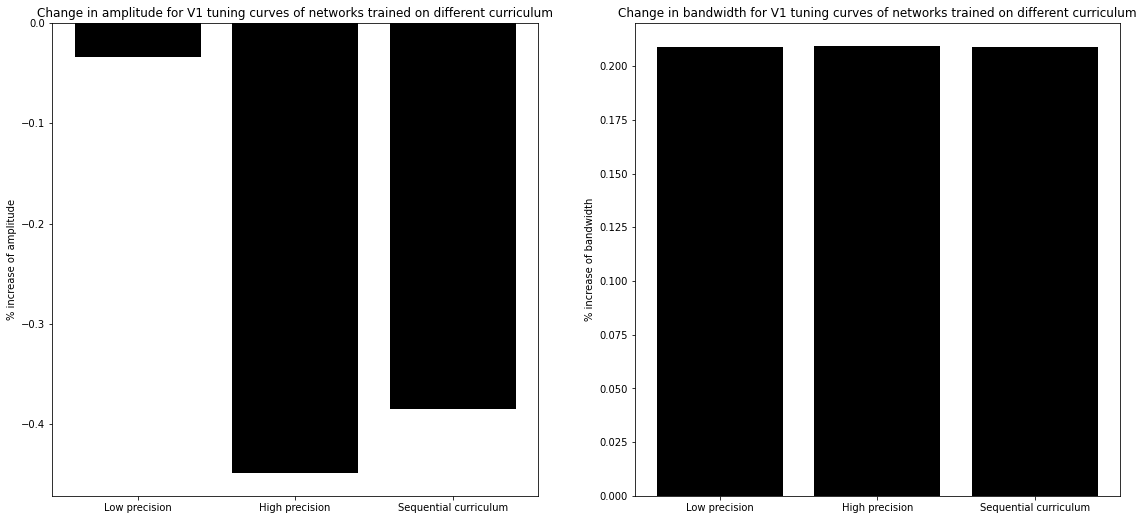

In [13]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.amplitude_difference, net2.amplitude_difference, net3.amplitude_difference], color = "black");
plt.ylabel("% increase of amplitude");
plt.title("Change in amplitude for V1 tuning curves of networks trained on different curriculum");

plt.subplot(4, 4, 2)
plt.bar(["Low precision", "High precision", "Sequential curriculum"], [
    net.bandwidth_difference, net2.bandwidth_difference, net3.bandwidth_difference], color = "black");
plt.ylabel("% increase of bandwidth");
plt.title("Change in bandwidth for V1 tuning curves of networks trained on different curriculum");

In [3]:
np.random.seed(2)
torch.manual_seed(2)

fixed_net = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, v4_size = 11, v4_stride = 6, phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.02)
x = fixed_net.inputting(-np.pi/180, np.pi/180, random_sf = False)
y = fixed_net.desired_outputting()
optimizer = optim.SGD(fixed_net.parameters(), lr = fixed_net.alpha)
fixed_net.mean_train(3000, optimizer)

random_net = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, v4_size = 11, v4_stride = 6, phis_sfs = 4, training_size = 2, phis = True, sfs = False, alpha = 0.02)
x = random_net.inputting(-np.pi/36, np.pi/36, random_sf = True)
y = random_net.desired_outputting()
optimizer = optim.SGD(random_net.parameters(), lr = random_net.alpha)
random_net.mean_train(3000, optimizer)

100%|██████████| 100/100 [00:00<00:00, 430.60it/s]


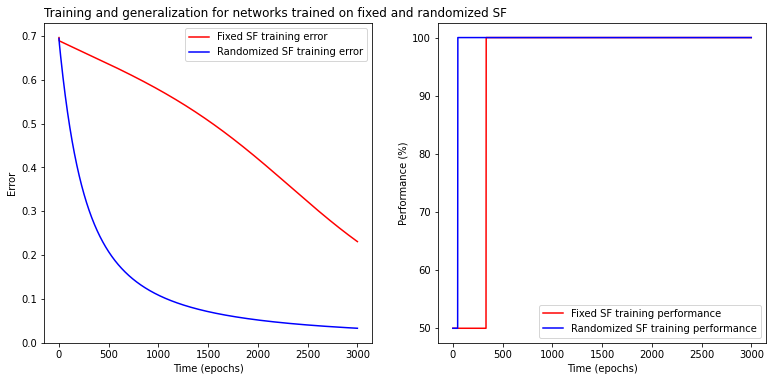

In [4]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
fixed_net.plot_training_error('red')
random_net.plot_training_error('blue')
plt.legend(["Fixed SF training error", "Randomized SF training error"]);
plt.title("Training and generalization for networks trained on fixed and randomized SF", loc = "left")

plt.subplot(3, 3, 2)
fixed_net.plot_training_performance('red')
random_net.plot_training_performance('blue')
plt.legend(["Fixed SF training performance", "Randomized SF training performance"]);


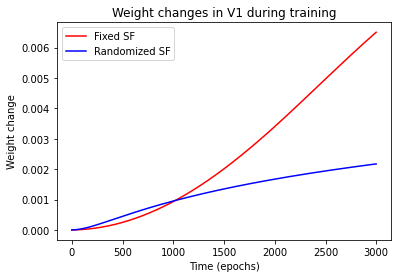

In [5]:
fixed_net.plot_weight_change('red', v1 = True)
random_net.plot_weight_change('blue', v1 = True)
plt.legend(["Fixed SF", "Randomized SF"]);
plt.title("Weight changes in V1 during training");

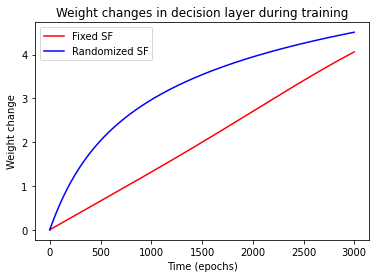

In [6]:
fixed_net.plot_weight_change('red', decision = True)
random_net.plot_weight_change('blue', decision = True)
plt.legend(["Fixed SF", "Randomized SF"]);
plt.title("Weight changes in decision layer during training");

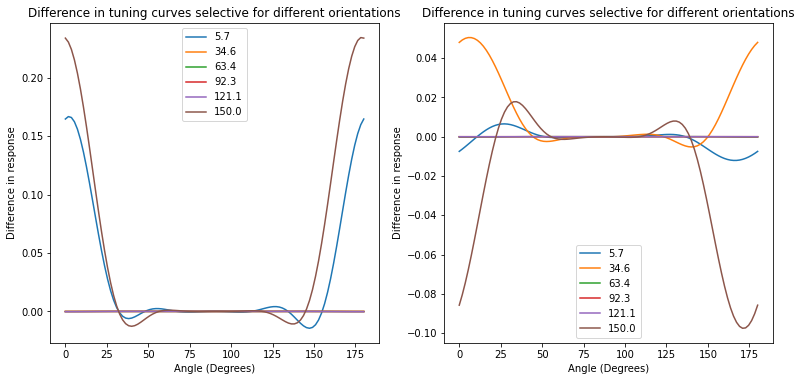

In [7]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
fixed_net.plot_v1_tuning_curve(orientation = 0, phi_sf = 1, position = 12, orientations = True, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

plt.subplot(3, 3, 2)
random_net.plot_v1_tuning_curve(orientation = 0, phi_sf = 1, position = 12, orientations = True, differences = True)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

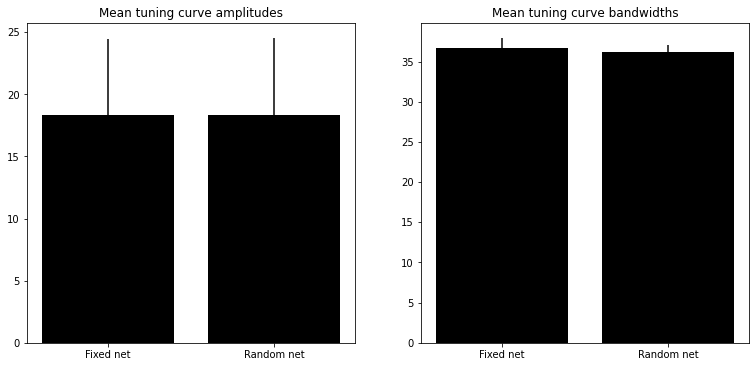

In [8]:
fixed_net.tuning_params(12)
random_net.tuning_params(12)

plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
plt.bar(["Fixed net", "Random net"], [fixed_net.mean_after_amplitude, random_net.mean_after_amplitude], yerr = [
    fixed_net.std_after_amplitude, random_net.std_after_amplitude], color = "black");
plt.title("Mean tuning curve amplitudes");

plt.subplot(3, 3, 2)
plt.bar(["Fixed net", "Random net"], [fixed_net.mean_after_bandwidth, random_net.mean_after_bandwidth], yerr = [
    fixed_net.std_after_bandwidth, random_net.std_after_bandwidth], color = "black");
plt.title("Mean tuning curve bandwidths");

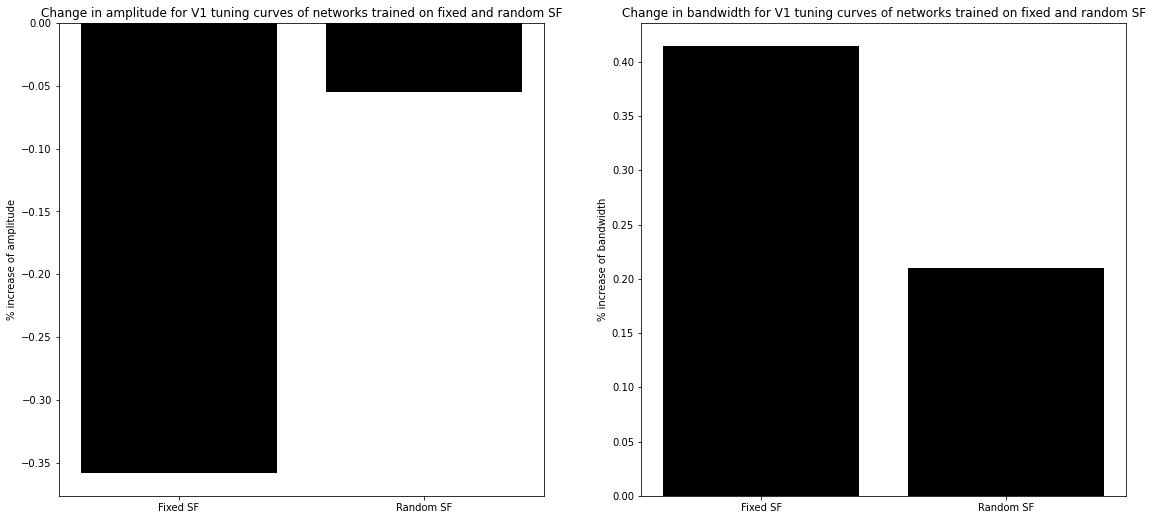

In [9]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
plt.bar(["Fixed SF", "Random SF"], [fixed_net.amplitude_difference, random_net.amplitude_difference], color = "black");
plt.ylabel("% increase of amplitude");
plt.title("Change in amplitude for V1 tuning curves of networks trained on fixed and random SF");

plt.subplot(4, 4, 2)
plt.bar(["Fixed SF", "Random SF"], [fixed_net.bandwidth_difference, random_net.bandwidth_difference], color = "black");
plt.ylabel("% increase of bandwidth");
plt.title("Change in bandwidth for V1 tuning curves of networks trained on fixed and random SF");

In [21]:
# print(np.mean(fixed_net.after_bandwidths))
# print(np.mean(random_net.after_bandwidths))
print(fixed_net.mean_after_bandwidth)
print(random_net.mean_after_bandwidth)
print(fixed_net.mean_before_bandwidth)
print(random_net.mean_before_bandwidth)


36.51515151515152
36.06060606060606
36.51515151515152
36.13636363636364


In [4]:
np.random.seed(2)
torch.manual_seed(2)

fixed_net2 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, v4_size = 11, v4_stride = 6, phis_sfs = 5, training_size = 2, phis = False, sfs = True, alpha = 0.02)
x = fixed_net2.inputting(-np.pi/180, np.pi/180, random_sf = False)
y = fixed_net2.desired_outputting()
optimizer = optim.SGD(fixed_net2.parameters(), lr = fixed_net2.alpha)
fixed_net2.mean_train(3000, optimizer)
fixed_net2.tuning_curve()


random_net2 = LCN(
    input_size = 33, simple_number = 6, simple_size = 11, v4_size = 11, v4_stride = 6, phis_sfs = 5, training_size = 2, phis = False, sfs = True, alpha = 0.02)
x = random_net2.inputting(-np.pi/36, np.pi/36, random_sf = True)
y = random_net2.desired_outputting()
optimizer = optim.SGD(random_net2.parameters(), lr = random_net2.alpha)
random_net2.mean_train(3000, optimizer)
random_net2.tuning_curve()

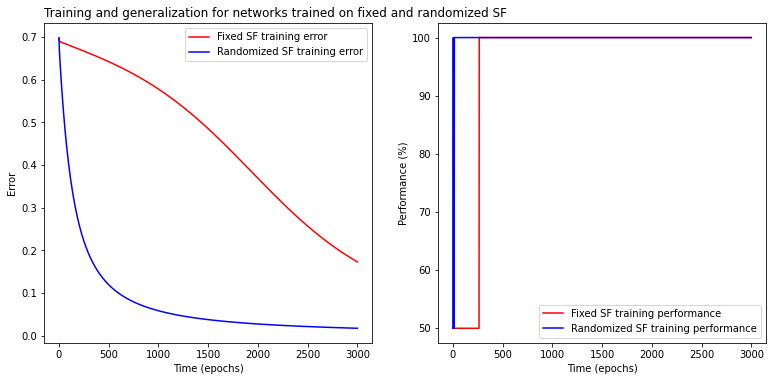

In [5]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
fixed_net2.plot_training_error('red')
random_net2.plot_training_error('blue')
plt.legend(["Fixed SF training error", "Randomized SF training error"]);
plt.title("Training and generalization for networks trained on fixed and randomized SF", loc = "left")

plt.subplot(3, 3, 2)
fixed_net2.plot_training_performance('red')
random_net2.plot_training_performance('blue')
plt.legend(["Fixed SF training performance", "Randomized SF training performance"]);


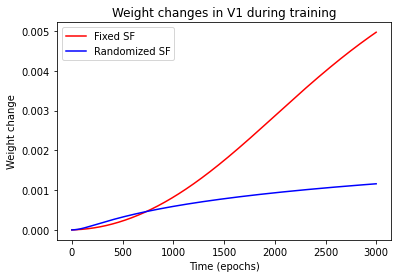

In [6]:
fixed_net2.plot_weight_change('red', v1 = True)
random_net2.plot_weight_change('blue', v1 = True)
plt.legend(["Fixed SF", "Randomized SF"]);
plt.title("Weight changes in V1 during training");

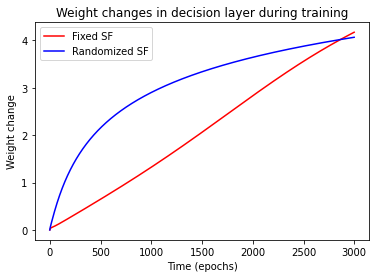

In [7]:
fixed_net2.plot_weight_change('red', decision = True)
random_net2.plot_weight_change('blue', decision = True)
plt.legend(["Fixed SF", "Randomized SF"]);
plt.title("Weight changes in decision layer during training");

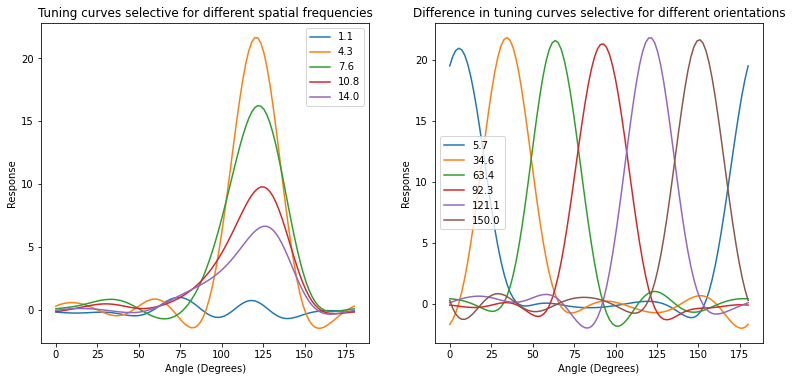

In [19]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
fixed_net2.plot_tuning_curve(orientation = 4, phi_sf = 2, position = 12, phi_sfs = True, differences = False)
plt.title("Tuning curves selective for different spatial frequencies", loc = 'center');

plt.subplot(3, 3, 2)
random_net2.plot_tuning_curve(orientation = 4, phi_sf = 1, position = 12, orientations = True, differences = False)
plt.title("Difference in tuning curves selective for different orientations", loc = 'center');

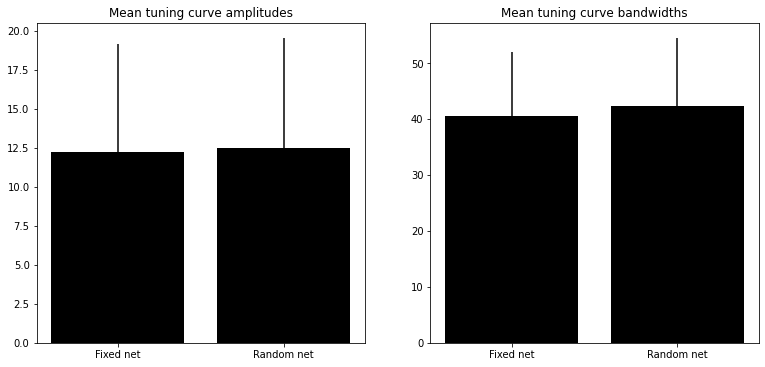

In [9]:
fixed_net2.tuning_params(12)
random_net2.tuning_params(12)

plt.figure(figsize = [20, 20])

plt.subplot(3, 3, 1)
plt.bar(["Fixed net", "Random net"], [fixed_net2.mean_after_amplitude, random_net2.mean_after_amplitude], yerr = [
    fixed_net2.std_after_amplitude, random_net2.std_after_amplitude], color = "black");
plt.title("Mean tuning curve amplitudes");

plt.subplot(3, 3, 2)
plt.bar(["Fixed net", "Random net"], [fixed_net2.mean_after_bandwidth, random_net2.mean_after_bandwidth], yerr = [
    fixed_net2.std_after_bandwidth, random_net2.std_after_bandwidth], color = "black");
plt.title("Mean tuning curve bandwidths");

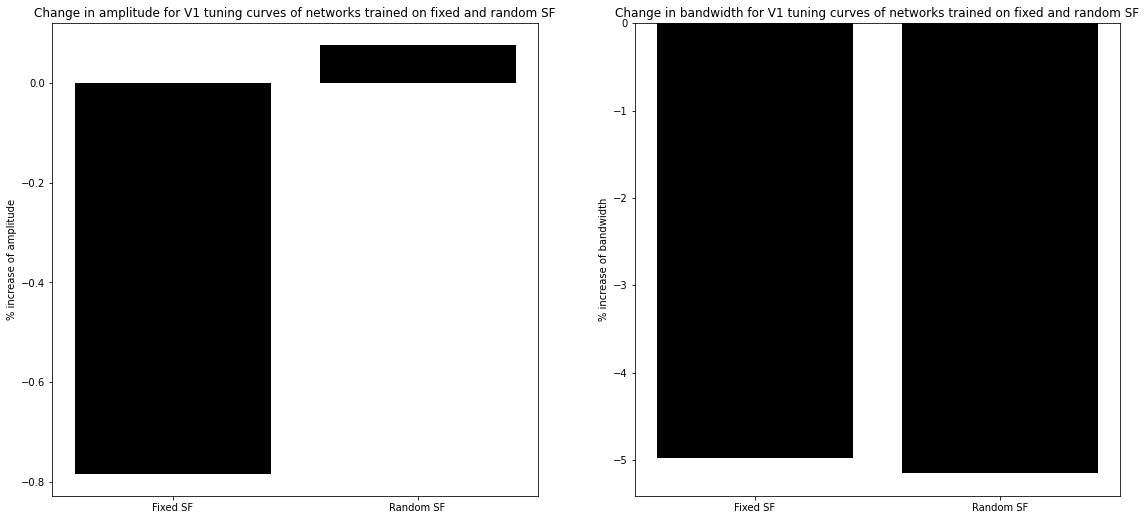

In [10]:
plt.figure(figsize = [40, 40])

plt.subplot(4, 4, 1)
plt.bar(["Fixed SF", "Random SF"], [fixed_net2.amplitude_difference, random_net2.amplitude_difference], color = "black");
plt.ylabel("% increase of amplitude");
plt.title("Change in amplitude for V1 tuning curves of networks trained on fixed and random SF");

plt.subplot(4, 4, 2)
plt.bar(["Fixed SF", "Random SF"], [fixed_net2.bandwidth_difference, random_net2.bandwidth_difference], color = "black");
plt.ylabel("% increase of bandwidth");
plt.title("Change in bandwidth for V1 tuning curves of networks trained on fixed and random SF");

In [ ]:
curve = fixed_net.results[1, 0, 12, 12, :]
initial_params = fixed_net.initial_tuning_curves[1, 0, 12, 12, :]
plt.plot(curve)
plt.plot(initial_params)

x = np.linspace(0, np.pi, 100)
x = (x * 180) / np.pi

def find_nearest(tensor, value):
        idx = (torch.abs(tensor - value)).argmin()
        return idx.item()

    
halfmax_amplitude = torch.abs(curve.max()) - torch.abs(curve.min())
halfmax = halfmax_amplitude/2
halfmax_index1 = find_nearest(curve, halfmax)
temporary = torch.cat([curve[0:halfmax_index1], curve[halfmax_index1+1:]])
halfmax_index2 = find_nearest(temporary, halfmax)
add = 0
while halfmax_index1-2 <= halfmax_index2 <= halfmax_index1+2:
                    temporary = torch.cat([temporary[0:halfmax_index2], temporary[halfmax_index2+1:]])
                    halfmax_index2 = find_nearest(temporary, halfmax)
                    add += 1

if halfmax_index1 < halfmax_index2:
    halfmax_index2 += 1
try1 = np.abs(x[halfmax_index1] - x[halfmax_index2])
try2 = 180 - np.abs(x[halfmax_index1] - x[halfmax_index2])
if try1 < try2:
    bandwidth = try1
else:
    bandwidth = try2



halfmax2_amplitude2 = torch.abs(initial_params.max()) - torch.abs(initial_params.min())
halfmax2 = halfmax2_amplitude2/2
halfmax2_index1 = find_nearest(initial_params, halfmax2)
temporary2 = torch.cat([initial_params[0:halfmax2_index1], initial_params[halfmax2_index1+1:]])
halfmax2_index2 = find_nearest(temporary2, halfmax2)
add = 0
while halfmax2_index1-2 <= halfmax2_index2 <= halfmax2_index1+2:
                    temporary = torch.cat([temporary[0:halfmax2_index2], temporary[halfmax2_index2+1:]])
                    halfmax2_index2 = find_nearest(temporary, halfmax2)
                    add += 1
if halfmax2_index1 < halfmax2_index2:
    halfmax2_index2 += 1
try1 = np.abs(x[halfmax2_index1] - x[halfmax2_index2])
try2 = 180 - np.abs(x[halfmax2_index1] - x[halfmax2_index2])
if try1 < try2:
    bandwidth2 = try1
else:
    bandwidth2 = try2

bandwidth, bandwidth2
halfmax, halfmax_index1, halfmax_index2, halfmax2_index1


In [ ]:
print(fixed_net.before_bandwidths == fixed_net.after_bandwidths)

In [ ]:
print(fixed_net.initial_tuning_curves[0][0][12][12][:]) 
print(random_net.initial_tuning_curves[0][0][12][12][:])

In [ ]:
for i in fixed_net.parameters():
    print(i)

In [ ]:
input = torch.rand(1, 1, 5, 5)
weight = torch.randn(1, 4, 1, 4, 4, 2**2)
input

In [ ]:
weight.shape

In [ ]:
output = input.unfold(2, 2, 2).unfold(3, 2, 2)
output2 = output.contiguous().view(*output.size()[:-2],-1)
output2

In [ ]:
out = (output2.unsqueeze(1) * weight).sum([2,-1])
a = []
for i in range(0, 4, 2):
    a.append(torch.sum(out[0][i:i+2] ** 2, dim = 0))
out, torch.stack(a).view(2, 4, 4)

In [ ]:
weight.sum([2,-1])

In [ ]:
def generate_gabor(size, theta):
    ksize = size
    sigma = 3
    lamda = 5
    gamma = 0.5
    phi = 0
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
    return torch.tensor(kernel).view(1, 1, size, size).float()

angles = np.linspace(0, np.pi, 6)
weights = []
for i in range(6):
    for j in range(49):
        theta = angles[i]
        kernel = generate_gabor(5, theta)
        weights.append(kernel)
weight = torch.stack(weights).view(1, 6, 1, 7, 7, 25)
weights

In [ ]:

inputs = []

x = np.linspace(0, np.pi, 10)

for i in range(1):
    theta = x[i]
    kernel = generate_gabor(11, theta)
    inputs.append(kernel)

input = torch.stack(inputs).view(1, 1, 11, 11)
output = input.unfold(2, 5, 1).unfold(3, 5, 1)
output2 = output.contiguous().view(*output.size()[:-2],-1)
out = (output2.unsqueeze(1) * weight).sum([2,-1])
output2.shape

In [ ]:
x = np.linspace(0, 7, 6)
np.delete(x, -1)
x

In [ ]:
np.linspace(0, np.pi, 3), np.pi/2

In [ ]:
m = nn.MaxPool2d((2,2), stride = (2,2))
input = torch.rand(1, 1, 5, 5)
input, m(input)

In [ ]:
for i in range(0, 10, 2):
    print(i)

In [ ]:
fig, [ax1, ax2] = plt.subplots(1, 2)
ksize = 33
sigma = 3
lamda = 10
gamma = 0.5
phi = 0
theta = np.pi/4
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
kernel = torch.tensor(kernel)
noise = torch.normal(0, 0.05, (33,33))
kernel = kernel+ noise

ax1.imshow(kernel, 'gray')


ksize = 33
sigma = 3
lamda = 10
gamma = 0.5
phi = 0
theta = np.pi/4
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
kernel = torch.tensor(kernel)
noise = torch.normal(0, 0.1, (33,33))
kernel = kernel+ noise
ax2.imshow(kernel, 'gray')


In [ ]:
def gaussian(M, std):
    n = torch.arange(0, M) - (M - 1.0) / 2.0
    sig2 = 2 * std * std
    w = torch.exp(-n ** 2 / sig2)
    return w

def gkern(kernlen=256, std=128):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = gaussian(kernlen, std=std).reshape(kernlen)
    gkern2d = torch.outer(gkern1d, gkern1d)
    return gkern2d

# # Test plot
# plt.figure()
# plt.imshow(gkern(11, std=2), 'gray')
# plt.show()
# gkern(11, 2)

b = torch.empty(3, 3, 11, 11)
for i in range(3):
    for j in range(3):
        b[i][j] = gkern(11, 2)


In [ ]:
# input number: 1, input size: 3x3, weight size: 2x2, weight number 2
x = torch.rand(1, 3, 3)
weight = torch.rand(1, 2, 2, 4)
y = x.unfold(1, 2, 1).unfold(2, 2, 1)
z = y.contiguous().view(*y.size()[:-2], -1)
out = (z.unsqueeze(1)*weight).sum([1, -1])
out.shape

In [ ]:

def random():
    
    x = np.random.rand(1)
    y = torch.rand(1)
    return x, y


In [ ]:
np.random.seed(0)
torch.manual_seed(0)
random()

In [ ]:
device = torch.device('cuda')
device

In [ ]:
torch.manual_seed(0)
x = torch.rand(11)
halfmax = x.max()/2

def find_nearest(tensor, value):
    idx = (torch.abs(tensor - value)).argmin()
    return idx
a = find_nearest(x, halfmax)
temporary = torch.cat([x[0:a], x[a+1:]])
x[a], x[find_nearest(temporary, halfmax)]

In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device("cuda:0")
device

In [ ]:
torch.cuda.device_count()

In [ ]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))

In [ ]:
a = np.random.rand(5)
b = range(5)
plt.plot(a)
plt.errorbar(b, a, xerr = a.std(), yerr = a.std())
a.mean()

In [ ]:
a = torch.tensor([-1.2, -2, -3, -4, 0.2, 0.3])
(torch.abs(a.max())-torch.abs(a.min()))/2

In [29]:
!pip3 install tqdm


  Using cached tqdm-4.61.0-py2.py3-none-any.whl (75 kB)
